In [1]:
from scipy import constants as c
import scipy as sci
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from mpl_toolkits.axes_grid.axislines import SubplotZero
import os, time, json

C:\Users\Vidhate\Anaconda3\lib\site-packages\mpl_toolkits\axes_grid\__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


# Parameters Description
Rm : Lenght (mm) Magnet Radius  
lm : Length (mm) Magnet Length  
Nm : Number (num) Magnet 'turns'  
Br : (Tesla) Magnet remanence  
rc : Length (mm) Coil inner radius  
Rc : Length L(mm) Coil Outer radius  
lc : Length (mm) Coil Length  
Nz : Number (num) Coil turns in axial direction  
Nr : Number (num) Coil turns in radial direction  
I : (Ampere) Coil current  
zmin : Lenght (mm) Origin is at center of the coil. Leftmost position of   magnet from center of coil  
zmax : Length (mm) Rightmost position of magnet from center of coil  
step : Number (num) steps in which you want to split the zmax-zmin distance. Granularity  

In [2]:
param=json.loads(open("magCoilConfig.json").read())
mmTometre=1e-3
Rm = param['Rm'] * mmTometre # L(mm) Magnet Radius
lm = param['lm'] * mmTometre # L(mm) Magnet Length
Nm = param['Nm'] # (num) Magnet 'turns'
Br = param['Br'] # (Tesla) Magnet remanence
rc = param['rc'] * mmTometre # L(mm) Coil inner radius
Rc = param['Rc'] * mmTometre # L(mm) Coil Outer radius
lc = param['lc'] * mmTometre # L(mm) Coil Length
Nz = param['Nz'] # (num) Coil turns in axial direction
Nr = param['Nr'] # (num) Coil turns in radial direction
I = param['I'] # (Ampere) Coil current
zmin = param['zmin'] # (mm) Origin is at center of the coil. Leftmost position of magnet from center of coil
zmax = param['zmax'] # (mm) Rightmost position of magnet from center of coil
step = param['step'] # (num) steps in which you want to split the zmax-zmin distance. Granularity
zRange = np.arange(zmin, zmax, step) * mmTometre
N = Nz*Nr # Total number of turns in the coil

In [3]:
def Ff(r1, r2, z):
    term1=I*z*Br*lm/Nm
    m=4*r1*r2/((r1+r2)**2 + z**2)
    term2=m/(4*r1*r2)
    term2=np.power(term2,0.5)
    term3=special.ellipk(m)
    term4=((0.5*m)-1)/(m-1)
    term5=special.ellipe(m)
    Ff=term1*term2*(term3-(term4*term5))
    return Ff

In [4]:
def r(nr):
    term1=(nr-1)/(Nr-1)
    return rc+(term1*(Rc-rc))

In [5]:
def L(nm, nz):
    term1=(nz-1)/(Nz-1)
    term2=(nm-1)/(Nm-1)
    return (-0.5*(lm+lc))+(term1*lc)+(term2*lm)

In [6]:
def ForceFilament(z):
    F=0.0
    for nm in range(1,int(Nm)+1):
        for nr in range(1,int(Nr)+1):
            for nz in range(1,int(Nz)+1):
                rnr=r(nr)
                zL=z+L(nm, nz)
                f=Ff(rnr, Rm, zL)
                F+=f
    return F

Execution Time per 100 steps (s) : 6.128
Force (N) -1.5000547690752937
Sweet spot (mm) 7.400000000000674


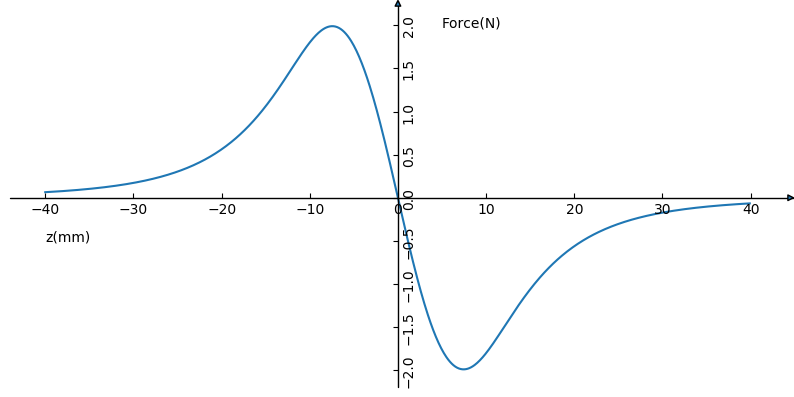

In [9]:
st=time.time()
Force=[]
for v in zRange:
    Force.append(ForceFilament(v))
print("Execution Time per 100 steps (s) : {:.03f}".format(np.around((time.time()-st)*100/len(zRange),3)))

print("Force (N)",np.amin(Force)/I)
print("Sweet spot (mm)",zRange[np.argmin(Force)]*1000)

fig=plt.figure(num=None, figsize=(10,5), dpi=100)
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)
for direction in ["xzero","yzero"]:
    ax.axis[direction].set_axisline_style("-|>")
    ax.axis[direction].set_visible(True)

plt.text(zmax/8,np.amax(Force),"Force(N)")
plt.text(zmin,np.amin(Force)/4, "z(mm)")

for direction in ["left", "right", "bottom", "top"]:
    ax.axis[direction].set_visible(False)
        
plt.plot(zRange*1e3,Force)
plt.savefig("MagCoilForceFigure.jpg")

In [10]:
ForceFil=Force
zFil=zRange

In [11]:
def t(e1,e2,z):
    term1=z+(0.5*e1*lm)+(0.5*e2*lc)
    return term1/Rm

def rho(e3):
    if e3==1:
        return Rc/Rm
    else:
        return rc/Rm

def m7(rho, t):
    den=(rho+1)**2 + (t**2)
    return (4*rho)/den

def m8(t):
    return np.power((t**2)+1,0.5)

def JacobiZeta(phi, m):
    return special.ellipeinc(phi, m) - (special.ellipe(m)*special.ellipkinc(phi,m)/special.ellipk(m))

def HeumannLambda(phi, m):
    term1=special.ellipkinc(phi,1-m)/special.ellipk(1-m)
    term2=(2/np.pi)*special.ellipk(m)*JacobiZeta(phi, 1-m)
    return term1+term2
    '''
    term1=special.ellipkinc(phi,1-m)
    term2=special.ellipe(m)
    term3=special.ellipk(m)
    term4=special.ellipeinc(phi,1-m)
    return (2/np.pi)*((term1*(term2-term3)) + (term4*term3))
    '''

def zeta1(rho, m7):
    term1=(rho-1)/(rho+1)
    term2=np.power(1/(1-m7),0.5)
    return np.arcsin(term1*term2)

def zeta2(t, m8):
    return np.arcsin(t/(1+m8))

def zeta3(t, m7, m8):
    term1=t/(1+m8)
    term2=np.power(1/(1-m7),0.5)
    return np.arcsin(term1*term2)

def psi1(rho, t, m7, m8):
    term1=special.ellipk(m7)
    term21=(m8+2)/(m8+1)
    term22=(t**2)-2
    term23=(rho**2)+rho+2
    term24=2/(rho+1)
    term2=(term21*term22)+term23-term24
    term3=(4*rho*special.ellipe(m7))/m7
    return (term1*term2)-term3

def psi2(rho, t, m7, m8):
    z1=np.absolute(zeta1(rho, m7))
    z2=np.absolute(zeta2(t, m8))
    z3=np.absolute(zeta3(t, m7, m8))
    term1=rho*np.sign(rho-1)*((rho**2)-3)*(HeumannLambda(z1, m7)-1)
    term2=HeumannLambda(z2, m7)-1
    term3=np.sign(rho-m8)*(HeumannLambda(z3, m7)-1)
    return term1+(m8*((t**2)-2)*(term2+term3))
    
def psi3(rho, t):
    phi=np.arange(0,np.pi*0.5,200)
    den=(np.sin(2*phi)**2) + (t**2)
    num=rho+np.cos(2*phi)
    term1=np.arcsinh(num/np.power(den,0.5))
    return np.trapz(term1,phi)

def f(rho, t, m7, psi1, psi2, psi3):
    term1=psi1*np.power((rho*m7),0.5)
    term2=(np.pi*psi2)/(2*np.absolute(t))
    term3=6*psi3
    return term1+term2+term3
    
def ForceBabic(z):
    F=0.0
    term1=(N*I*Br/6)*((Rm**3)/(lc*(Rc-rc)))
    eVal=[-1,1]
    for e1 in eVal:
        for e2 in eVal:
            for e3 in eVal:
                tval = t(e1,e2,z)
                if not tval==0:
                    rhoval = rho(e3)
                    m7val = m7(rhoval, tval)
                    m8val = m8(tval)
                    p1val = psi1(rhoval, tval, m7val, m8val)
                    p2val = psi2(rhoval, tval, m7val, m8val)
                    p3val = psi3(rhoval, tval)
                    fval = f(rhoval, tval, m7val, p1val, p2val, p3val)

                    F+=(e1*e2*e3*tval*fval)
    return F

Execution Time per 100 steps (s) : 0.075
Force (N) -0.21341741642526021
Sweet spot (mm) 8.800000000000695 -8.799999999999557


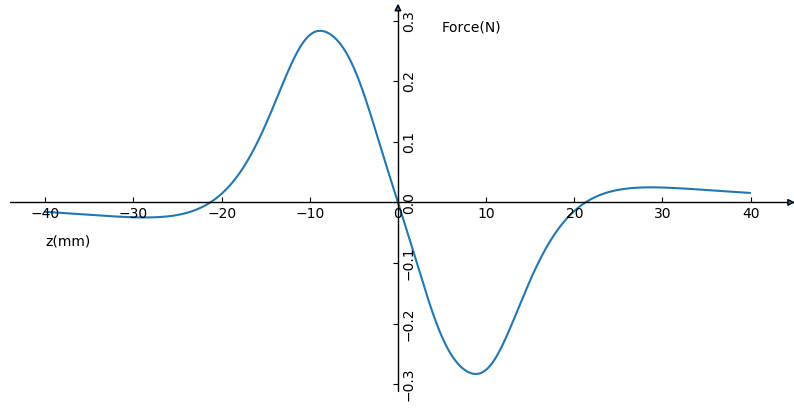

In [13]:
st=time.time()
Force=[]
for v in zRange:
    Force.append(ForceBabic(v))

ind=[i for i,F in enumerate(Force) if np.isnan(F)]
Force=np.delete(Force, ind)
zRange=np.delete(zRange, ind)

print("Execution Time per 100 steps (s) : {:.03f}".format(np.around((time.time()-st)*100/len(zRange),3)))
print("Force (N)",np.amin(Force)/I)
print("Sweet spot (mm)",zRange[np.argmin(Force)]*1000, zRange[np.argmax(Force)]*1000)

fig=plt.figure(num=None, figsize=(10,5), dpi=100)
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)
for direction in ["xzero","yzero"]:
    ax.axis[direction].set_axisline_style("-|>")
    ax.axis[direction].set_visible(True)

plt.text(zmax/8,np.amax(Force),"Force(N)")
plt.text(zmin,np.amin(Force)/4, "z(mm)")

for direction in ["left", "right", "bottom", "top"]:
    ax.axis[direction].set_visible(False)
        
plt.plot(zRange*1e3,Force)
#plt.plot(zFil*1e3, ForceFil)
plt.savefig("MagCoilForceFigure.jpg")

In [14]:
ForceBabic(0.009000000000000001)

C:\Users\Vidhate\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in arcsin


nan

In [91]:
a=np.array([10,20,30,40])
np.delete(a,1)

array([10, 30, 40])